In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

# Dark theme
plt.style.use('dark_background')

# set grid thickness
plt.rcParams['grid.linewidth'] = 0.3

DEBUG = False

# Nacteni dat

In [ ]:
def print_debug(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)

In [ ]:
def load_data():
    DEBUG = True
    excel_file = pd.ExcelFile("Projekt-2_Data.xlsx")
    print_debug(excel_file.sheet_names)

    df_uloha_1: pd.DataFrame = excel_file.parse(excel_file.sheet_names[0])
    df_uloha_2 = excel_file.parse(excel_file.sheet_names[1])
    print_debug(df_uloha_1.head())
    print_debug(df_uloha_2.head())
    return {
        '1': df_uloha_1,
        '1_a': df_uloha_1['uloha_1 a)'],
        '1_b_prior': df_uloha_1['uloha_1 b)_prior'],
        '1_g': df_uloha_1['skupina'],
        '1_b_observation': df_uloha_1['uloha_1 b)_pozorování'],
        '2': df_uloha_2,
        '2_os': df_uloha_2['OSType'],
        '2_as': df_uloha_2['ActiveUsers'],
        '2_ip': df_uloha_2['InteractingPct'],
        '2_sp': df_uloha_2['ScrollingPct'],
        '2_p': df_uloha_2['Ping [ms]'],
    }


data = load_data()

In [ ]:
# data

# ULOHA 1 - Bayesovske odhady

## ULOHA 1.a - Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení [2 body]

### Cleaning data
- Remove outliers

In [ ]:
def task_1_b_data():
    connections = 10
    time = 5
    info_df1 = data
    return {
        'connections': connections,
        'time': time,
        'info_df1': info_df1
    }

In [ ]:
def task_1_b_cleared_data(df_uloha_1: pd.DataFrame):
    # Extract observed data
    observed_data = df_uloha_1.values
    print_debug(f"{observed_data=}")
    print_debug(f"{len(observed_data)=}")

    # remove nan or +-inf values
    observed_data = observed_data[~np.isnan(observed_data)]
    print_debug(f"{observed_data=}")
    print_debug(f"{len(observed_data)=}")

    # Calculate Z-scores
    z_scores = stats.zscore(observed_data, nan_policy='raise')
    print_debug(f"{z_scores=}")
    print_debug(f"{len(observed_data)=}")

    # Define a threshold for outliers (e.g., 3 standard deviations)
    threshold = 3

    # Filter out rows with Z-scores beyond the threshold
    filtered_data = observed_data[(np.abs(z_scores) < threshold)]
    print_debug(f"{filtered_data=}")
    print_debug(f"{len(observed_data)=}")

    # Display the number of removed outliers
    print_debug(f"Number of removed outliers: {len(df_uloha_1.values) - len(filtered_data)}")
    return filtered_data


filtered_data = task_1_b_cleared_data(data['1_a'])
filtered_data

## ULOHA 1.a.1 - Do jednoho obrázku vykreslíte apriorní a aposteriorní hustotou parametru Poissonova rozdělení $\lambda$.

In [ ]:
def task_1_a_1_data():
    # Expertní odhad parametru λ
    lambda_expert = 10 / 5  # 10 připojení za 5 ms
    alpha_prior = 10  # connection count
    # alpha_prior = 2
    beta_prior = 5  # time within the connection count (alpha_prior) was observed
    # beta_prior = 1
    return {
        'lambda_expert': lambda_expert,
        'alpha_prior': alpha_prior,
        'beta_prior': beta_prior
    }

In [ ]:
def task_1_a_1_prior():
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']
    
    # lambda prior
    lambda_prior = alpha_prior / beta_prior
    print_debug(f"{lambda_prior=}")

    x = np.linspace(0, np.max(filtered_data), 1000)
    y = stats.gamma.pdf(x, alpha_prior, scale=1 / beta_prior)
    return {
        'x': x,
        'y': y,
        "alpha_prior": alpha_prior,
        "beta_prior": beta_prior
    }


In [ ]:
def task_1_a_1_posterior():
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']
    
    # posterior
    alpha_posterior = alpha_prior + np.sum(filtered_data)
    beta_posterior = beta_prior + len(filtered_data)

    # lambda_posterior
    lambda_posterior = alpha_posterior / beta_posterior
    print_debug(f"{lambda_posterior=}")

    # Posterior
    x = np.linspace(0, np.max(filtered_data), 1000)
    y = stats.gamma.pdf(x, alpha_posterior, scale=1 / beta_posterior)
    return {
        'x': x,
        'y': y,
        "alpha_posterior": alpha_posterior,
        "beta_posterior": beta_posterior
    }

In [ ]:
def task_1_a_1_plot():
    data_prior = task_1_a_1_prior()
    x = task_1_a_1_prior()['x']
    y = task_1_a_1_prior()['y']
    plt.plot(x, y, label = 'Posterior', color = 'blue')
    data_posterior = task_1_a_1_posterior()
    x = task_1_a_1_posterior()['x']
    y = task_1_a_1_posterior()['y']
    plt.plot(x, y, label = 'Posterior', color = 'red')
    plt.title('Prior and Posterior Distributions')
    plt.xlabel('Lambda')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()
task_1_a_1_plot()

## ULOHA 1.a.2 - Do jednoho obrázku vykreslíte apriorní a aposteriorní prediktivní hustotou pozorovaní $x$ za jeden časový interval.

In [ ]:
def task_1_a_2_prior():
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']
    lambda_prior = data['lambda_expert']

    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)

    lambda_posterior = alpha_posterior / beta_posterior
    print(f"{lambda_posterior=}")

    x = range(0, 6)
    y = stats.nbinom.pmf(x, alpha_prior, beta_prior / (1 + beta_prior))
    return x, y

In [ ]:
def task_1_a_2_posterior():
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']
    lambda_prior = data['lambda_expert']

    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)

    x = range(0, 6)
    y = stats.nbinom.pmf(x, alpha_posterior, beta_posterior / (1 + beta_posterior))
    return x, y

In [ ]:
def task_1_a_2_plot():
    x, y = task_1_a_2_prior()
    plt.plot(x, y, label='Prior predictive', color='blue')
    x, y = task_1_a_2_posterior()
    plt.plot(x, y, label='Prior predictive', color='red')
    plt.title('Prior and Posterior Predictive densities')
    plt.xlabel('How many (x) connections?')
    plt.ylabel('Probability of (x) connections')
    plt.legend()
    plt.show()
task_1_a_2_plot()

In [ ]:
def task_1_a_3():
    global DEBUG
    DEBUG = True
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']

    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)
    
    # Task 3: Construct 95% confidence intervals for λ from prior and posterior distributions
    prior_ci = stats.gamma.interval(0.95, alpha_prior, scale=1 / beta_prior)
    posterior_ci = stats.gamma.interval(0.95, alpha_posterior, scale=1 / beta_posterior)

    print_debug(f"Prior 95% CI for λ: {prior_ci[0]:.5f}, {prior_ci[1]:.5f}")
    print_debug(f"Posterior 95% CI for λ: {posterior_ci[0]:.5f}, {posterior_ci[1]:.5f}")
    
task_1_a_3()

In [ ]:
def task_1_a_4():
    global DEBUG
    DEBUG = True
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']
    
    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)
    
    # Task 4: Select two posterior point estimates for λ and compare them
    posterior_mean = alpha_posterior / beta_posterior
    posterior_mode = (alpha_posterior - 1) / beta_posterior

    print(f"Aposteriori mean: {posterior_mean:.5f}")
    print(f"Aposteriori mode: {posterior_mode:.5f}")
task_1_a_4()

In [ ]:
def task_1_a_5():
    global DEBUG
    DEBUG = True
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']
    
    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)
    
    # Task 5: Select one prior and one posterior point estimate for the number of observations
    mu_prior = alpha_prior / beta_prior
    mu_posterior = alpha_posterior / beta_posterior

    print(f"Prior estimate: {mu_prior:.5f}")
    print(f"Posterior estimate: {mu_posterior:.5f}")
task_1_a_5()

## ULOHA 1.b - Aproximace diskrétním rozdělením [2 body]

### Load data

In [43]:
def task_1_b_cleared_data(prior_data,
                          observed_data, 
                          group_column):
    global DEBUG
    DEBUG = 0

    #Filter inf and nan values
    prior_data = prior_data[~np.isnan(prior_data)]
    observed_data = observed_data[~np.isnan(observed_data)]
    group_column = group_column[~np.isnan(group_column)]
    print_debug(f"{prior_data=}")
    print_debug(f"{len(prior_data)=}")
    print_debug()
    print_debug(f"{observed_data=}")
    print_debug(f"{len(observed_data)=}")
    print_debug()
    print_debug(f"{group_column=}")
    print_debug(f"{len(group_column)=}")
    print_debug()
    return {
        'prior_data': prior_data,
        'observed_data': observed_data,
        'group_column': group_column
    }
    
# task_1_b_cleared_data(data['1_b_prior'], data['1_b_observation'], data['1_g'])

### Uloha 1.b.1: Plot prior, posterior, and likelihood functions

In [44]:
def task_1_b_1_data():
    global DEBUG
    # parameters for prior distribution
    mu = 3
    sigma_squared = 1
    a = 1
    return {
        'mu': mu,
        'sigma_squared': sigma_squared,
        'a': a
    }

In [46]:
# max_per_group = data['1'].groupby('skupina')['uloha_1 b)_prior'].max().reset_index()
max_per_group = data['1'].groupby('skupina')['uloha_1 b)_prior'].max()
# max_per_group = data['1']
max_per_group

skupina
0       5.021816
1       4.392436
2       5.827102
3       4.531723
4       5.461728
          ...   
9995    5.001767
9996    5.771658
9997    5.579720
9998    5.063841
9999    4.487418
Name: uloha_1 b)_prior, Length: 10000, dtype: float64

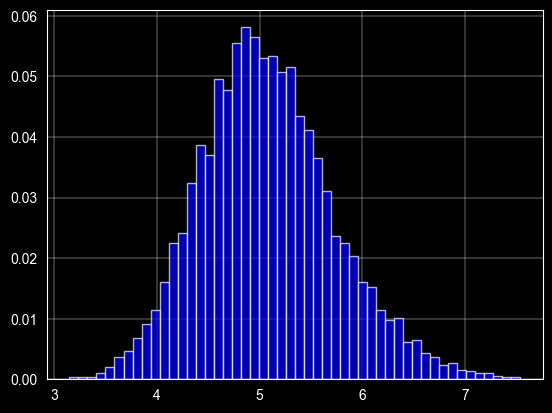

In [47]:
aprior_data_max = data['1'].groupby('skupina')['uloha_1 b)_prior'].max().reset_index()

# Získanie všetkých najväčších hodnôt do jednej dátovej sady
all_max_values = aprior_data_max['uloha_1 b)_prior']

# Určenie hraníc binov pre rovnomerné rozdelenie
all_max_values.max()
bin_width = (all_max_values.max() - all_max_values.min()) / 50
bins = np.arange(all_max_values.min(), all_max_values.max(), bin_width)

bin_height, bin_edges = np.histogram(all_max_values, bins=50)
bin_height = bin_height / np.sum(bin_height)

# Vytvorenie histogramu pre diskrétne rozdelenie
# plt.hist(all_max_values, bins=bins, edgecolor='black', alpha=0.7,density=True)
plt.bar(x=bins, height=bin_height, width=bin_width, color='blue', alpha=0.7)
plt.show()



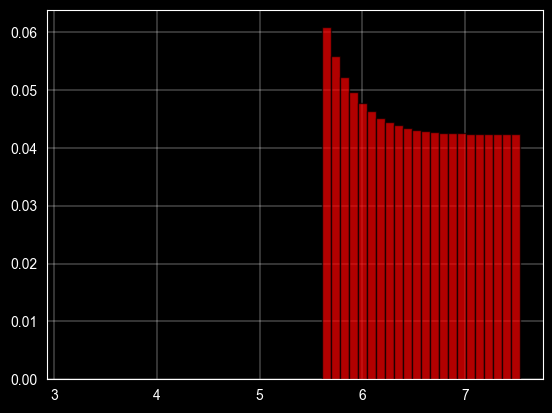

In [48]:
# Likelihood function
mu = 3
sigma = np.sqrt(1)
a = 1

observed_data = task_1_b_cleared_data(data['1_b_prior'], data['1_b_observation'], data['1_g'])['observed_data']
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
likelihood = np.zeros(50)

for i, b_center in enumerate(bin_centers):
    a_truncnorm = (a - mu) / sigma
    b_truncnorm = (b_center - mu) / sigma
    pdf = stats.truncnorm.pdf(observed_data, a=a_truncnorm, b=b_truncnorm, loc=mu, scale=sigma)
    pdf_product = np.prod(pdf)
    likelihood[i] = pdf_product

# likelihood
likelihood_normalized = likelihood / np.sum(likelihood)
plt.bar(x=bins, height=likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Likelyhood', alpha=0.7)
plt.show()

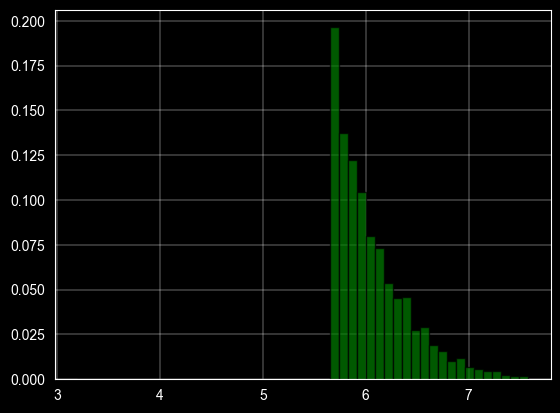

In [61]:
# Aposteriórna pst
posterior_probs = likelihood * bin_height
posterior_probs_normalized = posterior_probs / np.sum(posterior_probs)
plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green', label='Aposteriórne rozdelenie', alpha=0.7)
plt.show()

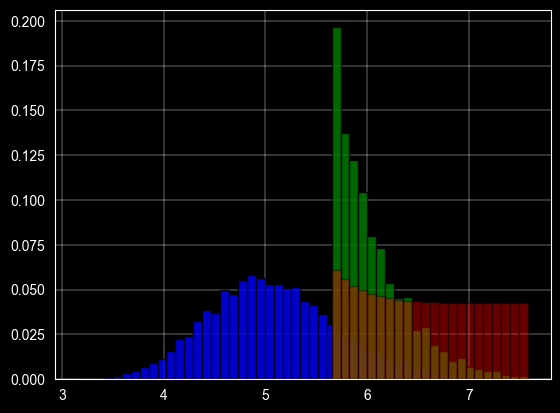

In [70]:
# Plot apriorné rozdelenie
plt.bar(x=bins, height=bin_height, width=bin_width, color='blue', alpha=0.8, edgecolor='black')
plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green', label='Aposteriórne rozdelenie', alpha=0.8)
plt.bar(bin_centers, likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Vierohodnosť', alpha=0.4)
plt.show()



In [74]:
# Určení 95% intervalu spolehlivosti
cumulative_posterior = np.cumsum(posterior_probs_normalized)
lower_bound = bin_centers[np.argmax(cumulative_posterior >= 0.025)]
upper_bound = bin_centers[np.argmax(cumulative_posterior >= 0.975)]
print(f'95% Confidence Interval for Parameter b: {lower_bound:.5f}, {upper_bound:.5f}')

95% Confidence Interval for Parameter b: 5.69371, 7.00891


In [75]:
# Vybrání dvou bodových odhadů
mean = np.sum(bin_centers * posterior_probs_normalized)
median = bin_centers[np.argmax(posterior_probs_normalized)]
print(f'First point estimate: {mean}')
print(f'Second point estimate: {median}') # Is this value OK?

First point estimate: 6.05277131983235
Second point estimate: 5.693712028182375


# ULOHA 2 - ÚLOHA 2 – Regrese – 8. bodů

In [ ]:
# Načtení dat
data = pd.read_csv('Data_v1.0.csv')

# Přidání kvadratických termínů
data['ActiveUsers_squared'] = data['ActiveUsers'] ** 2
data['InteractingPct_squared'] = data['InteractingPct'] ** 2
data['ScrollingPct_squared'] = data['ScrollingPct'] ** 2

# Přidání interakcí druhého řádu
data['ActiveUsers_InteractingPct'] = data['ActiveUsers'] * data['InteractingPct']
data['ActiveUsers_ScrollingPct'] = data['ActiveUsers'] * data['ScrollingPct']
data['InteractingPct_ScrollingPct'] = data['InteractingPct'] * data['ScrollingPct']

# Plný kvadratický model
model_formula = 'ping ~ ActiveUsers + InteractingPct + ScrollingPct + ActiveUsers_squared + InteractingPct_squared + ScrollingPct_squared + ActiveUsers_InteractingPct + ActiveUsers_ScrollingPct + InteractingPct_ScrollingPct + OSType'

# Fit regresního modelu
model = sm.OLS.from_formula(model_formula, data=data)
results = model.fit()

# Výpis výsledků
print(results.summary())

# Regresní diagnostika
sns.residplot(x=results.fittedvalues, y=results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Test normality reziduí
sm.qqplot(results.resid, line='s')
plt.title('Normal Q-Q plot')
plt.show()

# VIF pro detekci multicollinearity
X = data[['ActiveUsers', 'InteractingPct', 'ScrollingPct', 'ActiveUsers_squared', 'InteractingPct_squared',
          'ScrollingPct_squared', 'ActiveUsers_InteractingPct', 'ActiveUsers_ScrollingPct',
          'InteractingPct_ScrollingPct']]
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Identifikace odlehlých hodnot
influence = results.get_influence()
leverage = influence.hat_matrix_diag
residuals_studentized = influence.resid_studentized_internal
outliers = np.where((np.abs(residuals_studentized) > 2) | (leverage > 0.02))

# Vyhodnocení výsledků a rozhodnutí o odstranění odlehlých hodnot (pokud je to nutné)

# Analýza parametrů
param_analysis = results.params

# Identifikace nejproblematičtější hodnoty
max_residual = data.loc[outliers[0], 'ping'].max()

# Odhad odezvy uživatele s Windows
windows_user = pd.DataFrame({'ActiveUsers': [data['ActiveUsers'].mean()],
                             'InteractingPct': [data['InteractingPct'].mean()],
                             'ScrollingPct': [data['ScrollingPct'].mean()],
                             'ActiveUsers_squared': [data['ActiveUsers_squared'].mean()],
                             'InteractingPct_squared': [data['InteractingPct_squared'].mean()],
                             'ScrollingPct_squared': [data['ScrollingPct_squared'].mean()],
                             'ActiveUsers_InteractingPct': [data['ActiveUsers_InteractingPct'].mean()],
                             'ActiveUsers_ScrollingPct': [data['ActiveUsers_ScrollingPct'].mean()],
                             'InteractingPct_ScrollingPct': [data['InteractingPct_ScrollingPct'].mean()],
                             'OSType': ['Windows']})
predicted_ping = results.predict(windows_user)

# Konfidenční interval a predikční interval
conf_interval = results.get_prediction(windows_user).conf_int()
pred_interval = results.get_prediction(windows_user).conf_int(obs=True)

# Vyhodnocení modelu pro další použití
# Zde můžete diskutovat o tom, zda jsou výsledky modelu uspokojivé a zdali je model vhodný pro další použití.
